In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Sequence

In [2]:
import pandas as pd
train_data = pd.read_csv("/Users/carlbechtolsheim/code/Niki827/watt_squad/raw_data/train.csv")
test_data = pd.read_csv("/Users/carlbechtolsheim/code/Niki827/watt_squad/raw_data/test.csv")

In [3]:
train_data.head()

,time,pv_production,wind_production,consumption,spot_market_price,precip_1h:mm,precip_type:idx,prob_precip_1h:p,clear_sky_rad:W,clear_sky_energy_1h:J,...,t_50m:C,relative_humidity_50m:p,dew_point_50m:C,wind_speed_50m:ms,wind_dir_50m:d,t_100m:C,relative_humidity_100m:p,dew_point_100m:C,wind_speed_100m:ms,wind_dir_100m:d
0,2020-01-01 13:00:00,0.0,40.59,26.514689,0.28969,0.0,0.0,1.0,10.0,64826.0,...,8.4,60.7,1.3,8.4,246.3,8.3,60.3,1.0,10.4,247.3
1,2020-01-01 14:00:00,0.0,67.86,28.326960,0.29561,0.0,0.0,1.0,0.0,8961.1,...,8.4,61.6,1.5,8.0,252.3,8.4,60.7,1.2,10.0,252.1
2,2020-01-01 15:00:00,0.0,116.68,23.682207,0.30044,0.0,0.0,1.0,0.0,0.0,...,8.5,60.3,1.3,9.6,254.1,8.4,59.6,1.0,11.7,253.8
3,2020-01-01 16:00:00,0.0,120.22,25.354782,0.29975,0.0,0.0,1.0,0.0,0.0,...,8.4,63.9,2.0,12.1,254.6,8.3,63.4,1.7,14.3,254.2
4,2020-01-01 17:00:00,0.0,109.86,23.861942,0.29650,0.0,0.0,1.0,0.0,0.0,...,7.2,78.9,3.8,11.7,249.5,7.1,77.9,3.5,13.9,249.7


In [4]:
def load_training_data():
    data = pd.read_csv("/Users/carlbechtolsheim/code/Niki827/watt_squad/raw_data/train.csv")

    # Renaming columns
    data.rename(columns={'time': 'timestamp'}, inplace=True)
    data.rename(columns={'consumption': 'actual_consumption'}, inplace=True)
    data.rename(columns={'spot_market_price': 'electricity_price'}, inplace=True)

    # Calculating total actual_production
    data['actual_production'] = data['pv_production'] + data['wind_production']

    # Dropping irrelevant columns
    data = data[['timestamp', 'actual_consumption', 'actual_production', 'electricity_price']]

    return data

In [5]:
def actual_battery_percentage(capacity=500, initial_battery_percentage=0):
    """
    Calculate the actual battery percentage based on production and consumption.

    Args:
        capacity (float): Battery capacity in kWh (default is 500 kWh).
        initial_battery_percentage (float): Initial battery percentage (default is 0).

    Returns:
        DataFrame: Updated DataFrame with columns for battery status and grid purchases.
    """
    # Load data
    data = load_training_data()

    # Initialize new columns
    data['excess_production_kwH'] = data['actual_production'] - data['actual_consumption']
    data['battery_percentage'] = initial_battery_percentage
    data['electricity_bought_kwH'] = 0
    data['electricity_bought_NOK'] = 0

    # Iterate over each time step
    for i in range(len(data)):
        excess_production = data.loc[i, 'excess_production_kwH']
        battery_percentage = data.loc[i, 'battery_percentage']

        if excess_production > 0: # Excess production, charge the battery
            additional_charge = excess_production / capacity
            new_battery_percentage = battery_percentage + additional_charge
            data.loc[i, 'battery_percentage'] = min(new_battery_percentage, 1) # Cap at 100%

        elif excess_production < 0: # Deficit, discharge battery or buy from the grid
            required_discharge = abs(excess_production) /  capacity
            if battery_percentage >= required_discharge: # Sufficient battery
                data.loc[i, 'battery_percentage'] = battery_percentage - required_discharge
            else: # Insufficient battery, buy from grid
                data.loc[i, 'battery_percentage'] = 0
                shortfall_kwH = abs(excess_production) - (battery_percentage * capacity)
                data.loc[i, 'electricity_bought_kwH'] = shortfall_kwH
                data.loc[i, 'electricity_bought_NOK'] = shortfall_kwH * data.loc[i, 'electricity_price']

        # Carry forward the battery percentage to the next row
        if i < len(data) -1:
            data.loc[i+1, 'battery_percentage'] = data.loc[i, 'battery_percentage']

    return data

In [29]:
data = actual_battery_percentage(500)

In [44]:
data.head(10)

,timestamp,actual_consumption,actual_production,electricity_price,excess_production_kwH,battery_percentage,electricity_bought_kwH,electricity_bought_NOK
0,2020-01-01 13:00:00,26.514689,40.59,0.28969,14.075311,0.028151,0.0,0.0
1,2020-01-01 14:00:00,28.326960,67.86,0.29561,39.533040,0.107217,0.0,0.0
2,2020-01-01 15:00:00,23.682207,116.68,0.30044,92.997793,0.293212,0.0,0.0
3,2020-01-01 16:00:00,25.354782,120.22,0.29975,94.865218,0.482943,0.0,0.0
4,2020-01-01 17:00:00,23.861942,109.86,0.29650,85.998058,0.654939,0.0,0.0
5,2020-01-01 18:00:00,36.872878,71.79,0.28979,34.917122,0.724773,0.0,0.0
6,2020-01-01 19:00:00,56.876120,55.29,0.27273,-1.586120,0.721601,0.0,0.0
7,2020-01-01 20:00:00,23.773336,14.80,0.26957,-8.973336,0.703654,0.0,0.0
8,2020-01-01 21:00:00,20.893793,5.78,0.25527,-15.113793,0.673427,0.0,0.0
9,2020-01-01 22:00:00,19.516569,9.80,0.24471,-9.716569,0.653993,0.0,0.0


In [45]:
data.columns

Index(['timestamp', 'actual_consumption', 'actual_production',
       'electricity_price', 'excess_production_kwH', 'battery_percentage',
       'electricity_bought_kwH', 'electricity_bought_NOK'],
      dtype='object')

In [7]:
data['electricity_bought_NOK'].sum()

10169.204050523302

In [75]:
3 * (4*3)

36

In [174]:
def selling_electricity(battery_capacity: 500,
                       electricity_price_share: float):
    '''
    This function returns the costs a prosumer could have saved by selling electricity when production exceeds consumption and the battery is fully charged.
    '''

    # 1. Load data
    data = actual_battery_percentage(battery_capacity)

    # 2. Whenever production exceeds consumption and the battery is fully charged calculate kwH the user can sell
    data['electricity_sold_kwH'] = data.apply(
    lambda row: row['excess_production_kwH'] if row['actual_production'] > row['actual_consumption'] and row['battery_percentage'] == 1 else 0, 
    axis=1
    )

    # 3. Electricity price of sold electricity
    data['electricity_sold_NOK'] = data['electricity_sold_kwH'] * (data['electricity_price'] * electricity_price_share)

    electricity_sold = data['electricity_sold_NOK'].sum()

    electricity_bought = data['electricity_bought_NOK'].sum()

    # Convert 'timestamp' to datetime if not already
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    
    # Resample to hourly averages (if needed)
    hourly_data = data.set_index('timestamp')
    
    # Use .loc for date slicing
    june_data = hourly_data.loc['2020-06']
    december_data = hourly_data.loc['2020-12']

    return june_data, december_data, electricity_sold, electricity_bought

In [45]:
def selling_electricity(battery_capacity: 500,
                       electricity_price_share: float):
    '''
    This function returns the costs a prosumer could have saved by selling electricity
    when production exceeds consumption and the battery is fully charged.
    '''

    # 1. Load data
    data = actual_battery_percentage(battery_capacity)

    # 2. Whenever production exceeds consumption and the battery is fully charged calculate kwH the user can sell
    data['electricity_sold_kwH'] = data.apply(
    lambda row: row['excess_production_kwH'] if row['actual_production'] > row['actual_consumption'] and row['battery_percentage'] == 1 else 0,
    axis=1
    )

    # 3. Electricity price of sold electricity
    data['electricity_sold_NOK'] = data['electricity_sold_kwH'] * data['electricity_price'] * electricity_price_share

    electricity_sold_kwH = data['electricity_sold_kwH'].sum()
    electricity_sold_NOK = data['electricity_sold_NOK'].sum()


    electricity_bought_NOK = data['electricity_bought_NOK'].sum()

    # Convert 'timestamp' to datetime if not already
    data['timestamp'] = pd.to_datetime(data['timestamp'])

    # Resample to hourly averages (if needed)
    hourly_data = data.set_index('timestamp')

    # Use .loc for date slicing
    june_data = hourly_data.loc['2020-06']
    december_data = hourly_data.loc['2020-12']

    # Filter for the first 30 days of June and December
    june_data_30 = june_data[june_data.index.day <= 30]
    december_data_30 = december_data[december_data.index.day <= 30]
    
    june_data_30 = june_data_30.reset_index()
    december_data_30 = december_data_30.reset_index()

    june_data_30 = june_data_30.drop(columns = ['timestamp'])
    december_data_30 = december_data_30.drop(columns = ['timestamp'])

    return june_data_30, december_data_30, electricity_sold_kwH, electricity_sold_NOK, electricity_bought_NOK

In [46]:
june_data, december_data, electricity_sold_kwH, electricity_sold_NOK, electricity_bought_NOK = selling_electricity(500, 0.5)

In [47]:
june_data

,actual_consumption,actual_production,electricity_price,excess_production_kwH,battery_percentage,electricity_bought_kwH,electricity_bought_NOK,electricity_sold_kwH,electricity_sold_NOK
0,10.893502,1.280000,0.04852,-9.613502,0.763040,0.0,0.0,0.0,0.0
1,9.950489,6.570000,0.04874,-3.380489,0.756279,0.0,0.0,0.0,0.0
2,11.812247,0.303750,0.04243,-11.508497,0.733262,0.0,0.0,0.0,0.0
3,11.128673,1.401167,0.05216,-9.727507,0.713807,0.0,0.0,0.0,0.0
4,7.299278,2.558667,0.05066,-4.740612,0.704326,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
715,17.352060,19.499750,0.01593,2.147690,0.914080,0.0,0.0,0.0,0.0
716,14.346451,13.816167,0.01582,-0.530285,0.913020,0.0,0.0,0.0,0.0
717,17.204731,14.750000,0.01604,-2.454731,0.908110,0.0,0.0,0.0,0.0
718,14.115884,14.720000,0.01036,0.604116,0.909319,0.0,0.0,0.0,0.0


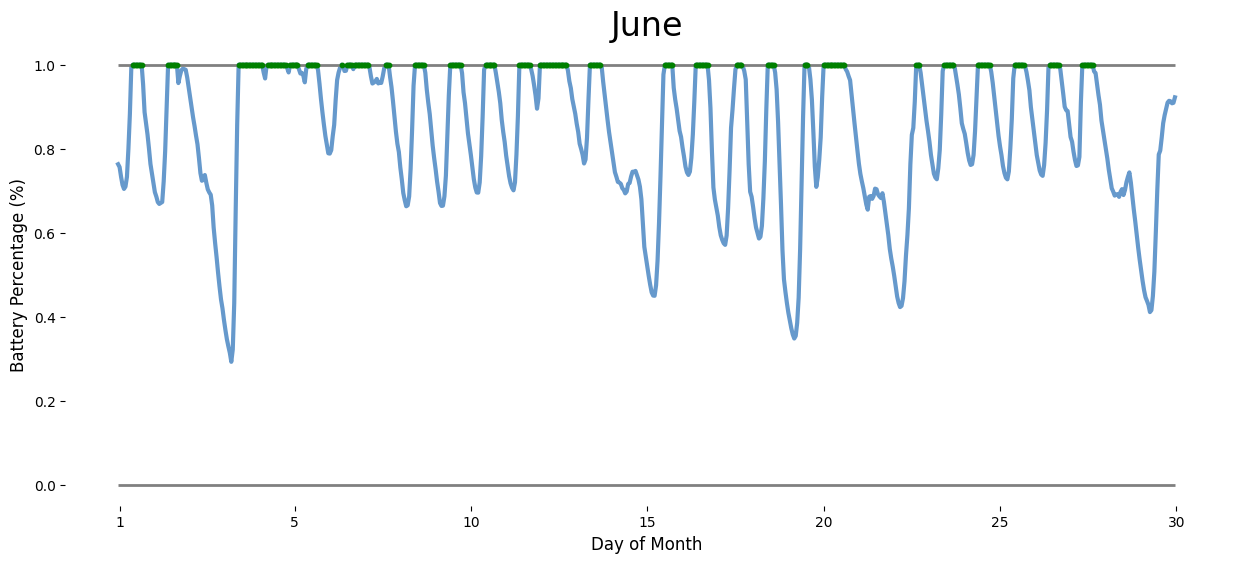

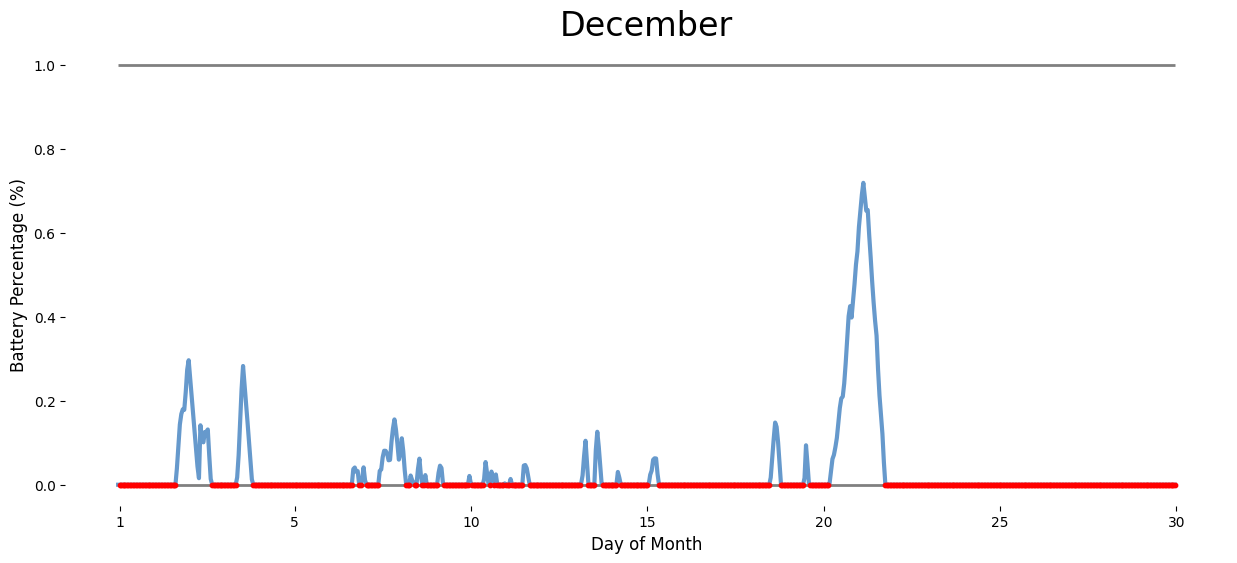

In [35]:
# Use .loc for date slicing
# Convert 'timestamp' to datetime if not already
#data['timestamp'] = pd.to_datetime(data['timestamp'])

# Resample to hourly averages (if needed)
#hourly_data = data.set_index('timestamp')

#june_data = hourly_data.loc['2020-06']
#december_data = hourly_data.loc['2020-12']

# Filter for the first 30 days of June and December
#june_data_30 = june_data[june_data.index.day <= 30]
#december_data_30 = december_data[december_data.index.day <= 30]

#june_data_30 = june_data_30.reset_index()
#december_data_30 = december_data_30.reset_index()

# Function to plot with color changes only when battery is 0 or 1 (using points and raw data)
def plot_with_color_changes(data, title):
    plt.figure(figsize=(15, 6))

    # Plot the raw data (battery_percentage) as a line
    plt.plot(data.index, data['battery_percentage'], color='#6699CC', linewidth=3)

    # Highlight points where battery_percentage is 0 or 1
    for i in range(1, len(data)):
        if data['battery_percentage'].iloc[i] == 1:
            plt.scatter(data.index[i], data['battery_percentage'].iloc[i], color='green', zorder=5, s=10)
        elif data['battery_percentage'].iloc[i] == 0:
            plt.scatter(data.index[i], data['battery_percentage'].iloc[i], color='red', zorder=5, s=10)

    # Draw thick grey horizontal lines at 0 and 1
    plt.hlines([0, 1], xmin=data.index.min(), xmax=data.index.max(), colors='grey', linestyles='-', linewidth=2)

        # Remove the frame around the plot
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    
    # Adjust y-axis limits to add space above and below
    plt.ylim(-0.05, 1.05)  # Adds space below 0 and above 1
    
    plt.title(title, fontsize = 24)
    plt.xlabel('Day of Month', fontsize=12)
    plt.ylabel('Battery Percentage (%)', fontsize=12)

    # Custom x-ticks (every 5th day)
    plt.xticks(ticks=[1, 120, 240, 360, 480, 600, 720], labels=[1, 5, 10, 15, 20, 25, 30])

    plt.grid(False)  # Disable default gridlines
    plt.show()

# Plot for June 2020 (no y-axis cap)
plot_with_color_changes(june_data_30, 'June')

# Plot for December 2020 with y-axis capped
plot_with_color_changes(december_data_30, 'December')

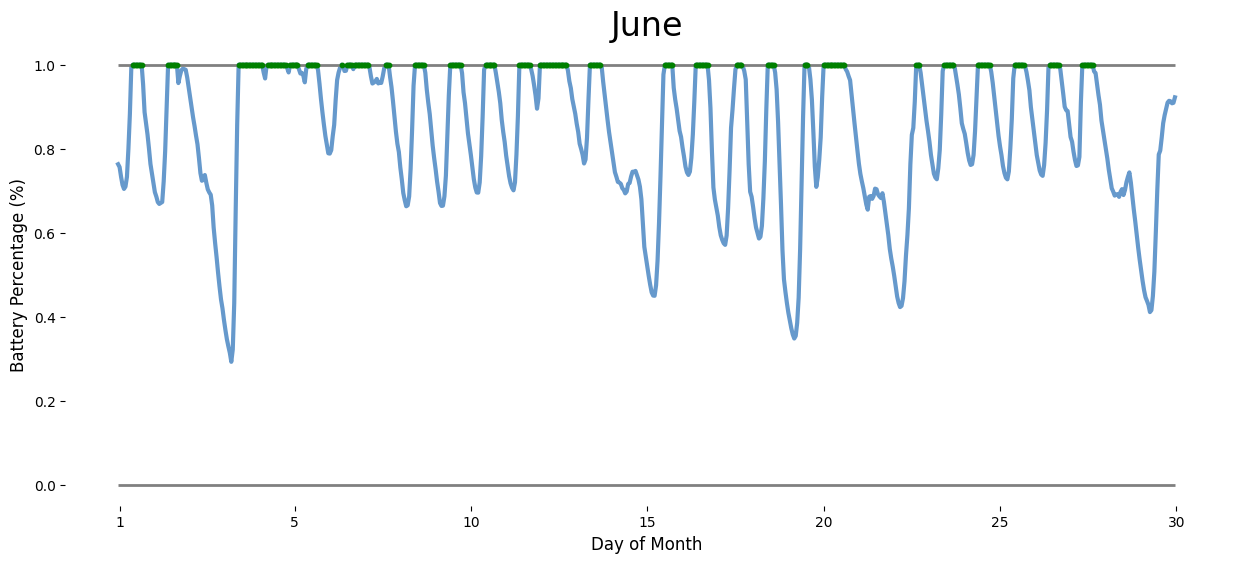

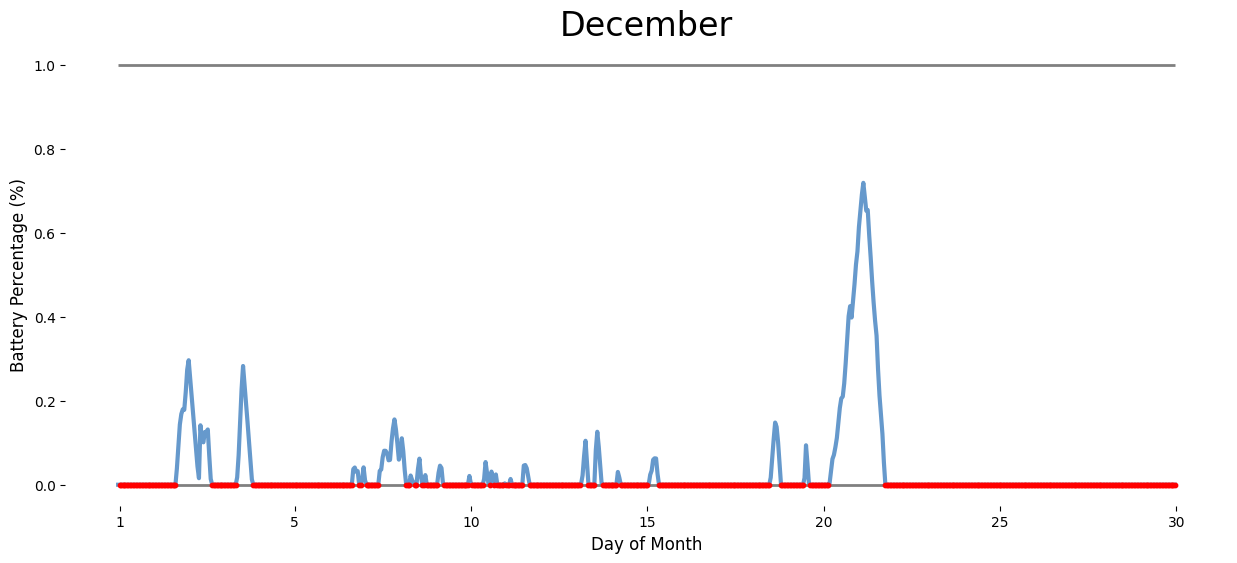

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Convert 'timestamp' to datetime if not already
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Resample to hourly averages (if needed)
hourly_data = data.set_index('timestamp')

# Use .loc for date slicing
june_data = hourly_data.loc['2020-06']
december_data = hourly_data.loc['2020-12']

# Filter for the first 30 days of June and December
june_data_30 = june_data[june_data.index.day <= 30]
december_data_30 = december_data[december_data.index.day <= 30]

june_data_30 = june_data_30.reset_index()
december_data_30 = december_data_30.reset_index()

# Function to plot with color changes only when battery is 0 or 1 (using points and raw data)
def plot_with_color_changes(data, title):
    plt.figure(figsize=(15, 6))

    # Plot the raw data (battery_percentage) as a line
    plt.plot(data.index, data['battery_percentage'], color='#6699CC', linewidth=3)

    # Highlight points where battery_percentage is 0 or 1
    for i in range(1, len(data)):
        if data['battery_percentage'].iloc[i] == 1:
            plt.scatter(data.index[i], data['battery_percentage'].iloc[i], color='green', zorder=5, s=10)
        elif data['battery_percentage'].iloc[i] == 0:
            plt.scatter(data.index[i], data['battery_percentage'].iloc[i], color='red', zorder=5, s=10)

    # Draw thick grey horizontal lines at 0 and 1
    plt.hlines([0, 1], xmin=data.index.min(), xmax=data.index.max(), colors='grey', linestyles='-', linewidth=2)

        # Remove the frame around the plot
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    
    # Adjust y-axis limits to add space above and below
    plt.ylim(-0.05, 1.05)  # Adds space below 0 and above 1
    
    plt.title(title, fontsize = 24)
    plt.xlabel('Day of Month', fontsize=12)
    plt.ylabel('Battery Percentage (%)', fontsize=12)

    # Custom x-ticks (every 5th day)
    plt.xticks(ticks=[1, 120, 240, 360, 480, 600, 720], labels=[1, 5, 10, 15, 20, 25, 30])

    plt.grid(False)  # Disable default gridlines
    plt.show()

# Plot for June 2020 (no y-axis cap)
plot_with_color_changes(june_data_30, 'June')

# Plot for December 2020 with y-axis capped
plot_with_color_changes(december_data_30, 'December')

<Axes: >

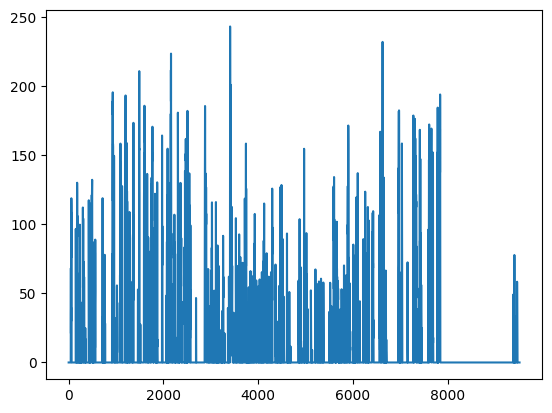

In [88]:
data['electricity_sold_kwH'].plot()

<Axes: >

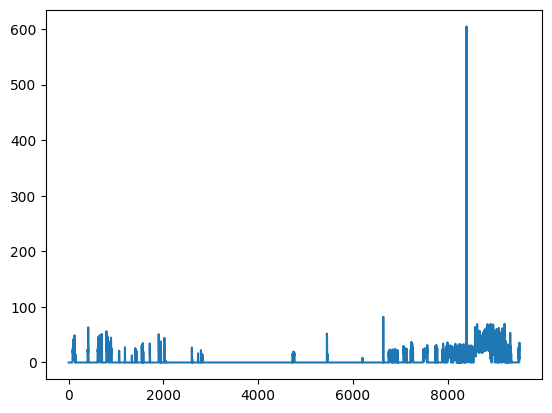

In [89]:
data['electricity_bought_kwH'].plot()

<Axes: >

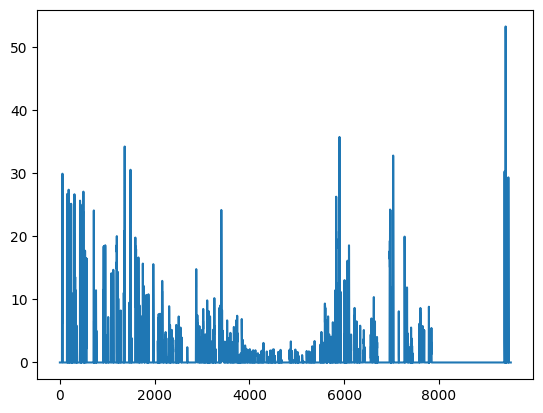

In [86]:
data['electricity_sold_NOK'].plot()

<Axes: >

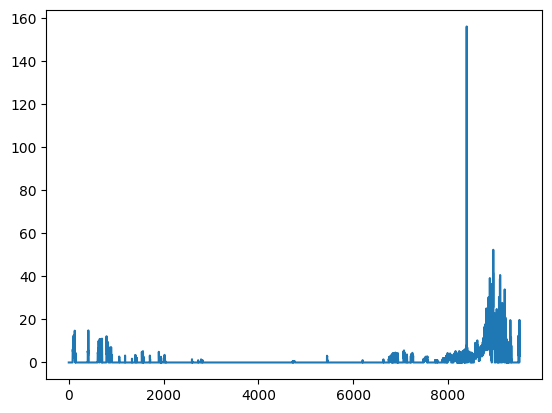

In [87]:
data['electricity_bought_NOK'].plot()

In [46]:
# Assuming you have your DataFrame called 'data'

# Add the 'electricity_sold_kwH' column based on the conditions
data['electricity_sold_kwH'] = data.apply(
    lambda row: row['excess_production_kwH'] if row['actual_production'] > row['actual_consumption'] and row['battery_percentage'] == 1 else 0, 
    axis=1
)


In [57]:
data['electricity_sold_NOK'] = data['electricity_sold_kwH'] * data['electricity_price']

In [58]:
data['electricity_sold_NOK'].sum()

11209.012393958348

In [59]:
data['electricity_bought_NOK'].sum()

10169.204050523302

In [63]:
data[data['electricity_sold_kwH']>0]

,timestamp,actual_consumption,actual_production,electricity_price,excess_production_kwH,battery_percentage,electricity_bought_kwH,electricity_bought_NOK,electricity_sold_kwH,electricity_sold_NOK
45,2020-01-03 10:00:00,26.197182,43.22,0.28355,17.022818,1.0,0.0,0.0,17.022818,4.826820
46,2020-01-03 11:00:00,22.549264,80.66,0.27892,58.110736,1.0,0.0,0.0,58.110736,16.208246
47,2020-01-03 12:00:00,22.557342,90.88,0.28020,68.322658,1.0,0.0,0.0,68.322658,19.144009
48,2020-01-03 13:00:00,25.652200,60.08,0.28533,34.427800,1.0,0.0,0.0,34.427800,9.823284
49,2020-01-03 14:00:00,26.001560,47.09,0.29419,21.088440,1.0,0.0,0.0,21.088440,6.204008
...,...,...,...,...,...,...,...,...,...,...
9463,2021-01-29 20:00:00,33.381440,68.81,0.50199,35.428560,1.0,0.0,0.0,35.428560,17.784783
9464,2021-01-29 21:00:00,32.080782,76.65,0.48213,44.569218,1.0,0.0,0.0,44.569218,21.488157
9465,2021-01-29 22:00:00,33.155542,66.84,0.44947,33.684458,1.0,0.0,0.0,33.684458,15.140153
9466,2021-01-29 23:00:00,28.905298,51.03,0.43754,22.124702,1.0,0.0,0.0,22.124702,9.680442


In [62]:
data.groupby('battery_percentage').count()

,timestamp,actual_consumption,actual_production,electricity_price,excess_production_kwH,electricity_bought_kwH,electricity_bought_NOK,electricity_sold_kwH,electricity_sold_NOK
battery_percentage,,,,,,,,,
0.000000,2005,2005,2005,2005,2005,2005,2005,2005,2005
0.000154,1,1,1,1,1,1,1,1,1
0.000365,1,1,1,1,1,1,1,1,1
0.000437,1,1,1,1,1,1,1,1,1
0.000477,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...
0.999715,1,1,1,1,1,1,1,1,1
0.999748,1,1,1,1,1,1,1,1,1
0.999817,1,1,1,1,1,1,1,1,1


# Graphs

In [8]:
import seaborn as sns

<Axes: ylabel='battery_percentage'>

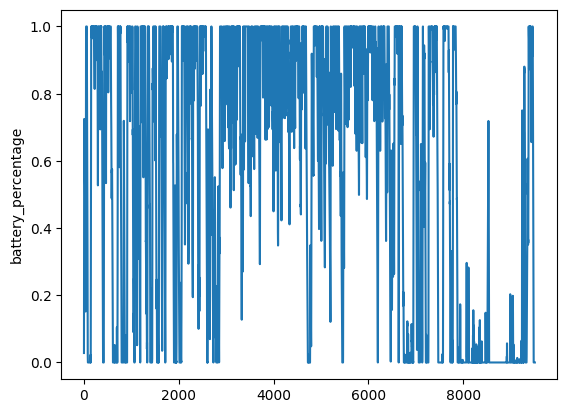

In [13]:
sns.lineplot(data['battery_percentage'])

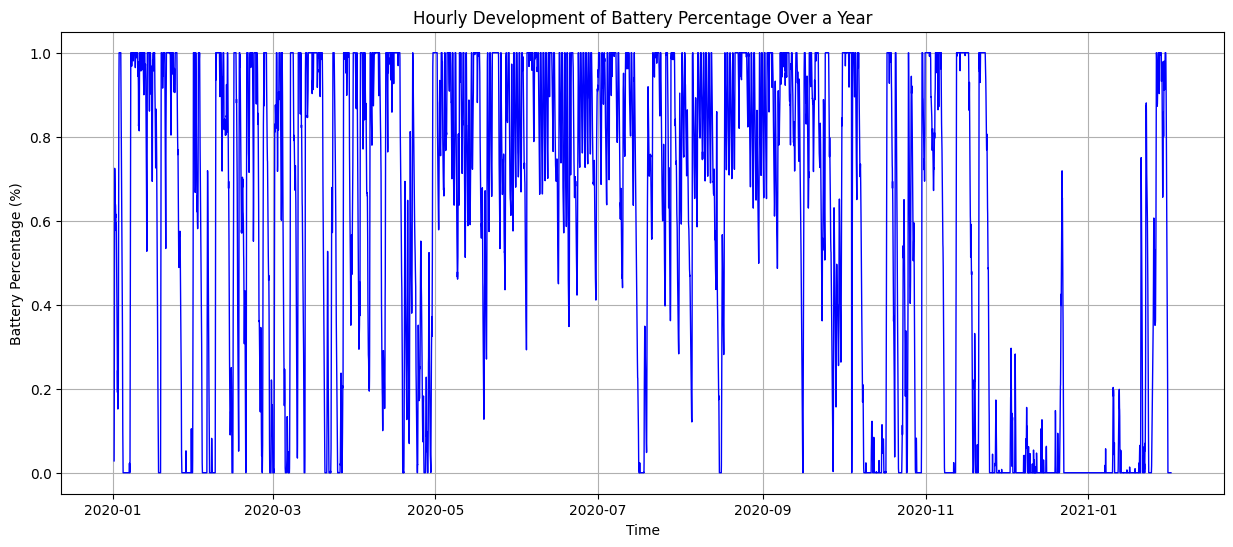

In [21]:
import matplotlib.pyplot as plt

# Assuming the DataFrame has columns 'timestamp' and 'battery_percentage'
# Convert 'timestamp' to datetime if not already
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Resample to hourly averages (if data has finer granularity)
hourly_data = data.set_index('timestamp').resample('H').mean()

# Plotting
plt.figure(figsize=(15, 6))
plt.plot(hourly_data.index, hourly_data['battery_percentage'], color='blue', linewidth=1)
plt.title('Hourly Development of Battery Percentage Over a Year')
plt.xlabel('Time')
plt.ylabel('Battery Percentage (%)')
plt.grid(True)
plt.show()

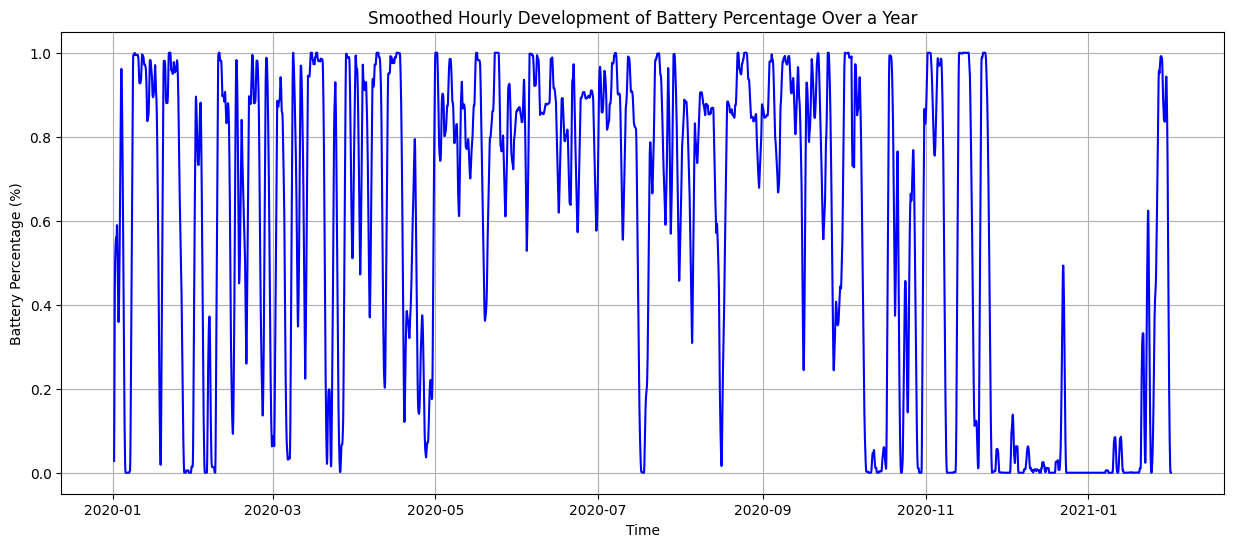

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming the DataFrame has columns 'timestamp' and 'battery_percentage'
# Convert 'timestamp' to datetime if not already
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Resample to hourly averages
hourly_data = data.set_index('timestamp').resample('H').mean()

# Apply a rolling average (e.g., 24-hour window for daily smoothing)
smoothed_data = hourly_data['battery_percentage'].rolling(window=24, min_periods=1).mean()

# Plotting
plt.figure(figsize=(15, 6))
plt.plot(hourly_data.index, smoothed_data, color='blue', linewidth=1.5)
plt.title('Smoothed Hourly Development of Battery Percentage Over a Year')
plt.xlabel('Time')
plt.ylabel('Battery Percentage (%)')
plt.grid(True)
plt.show()


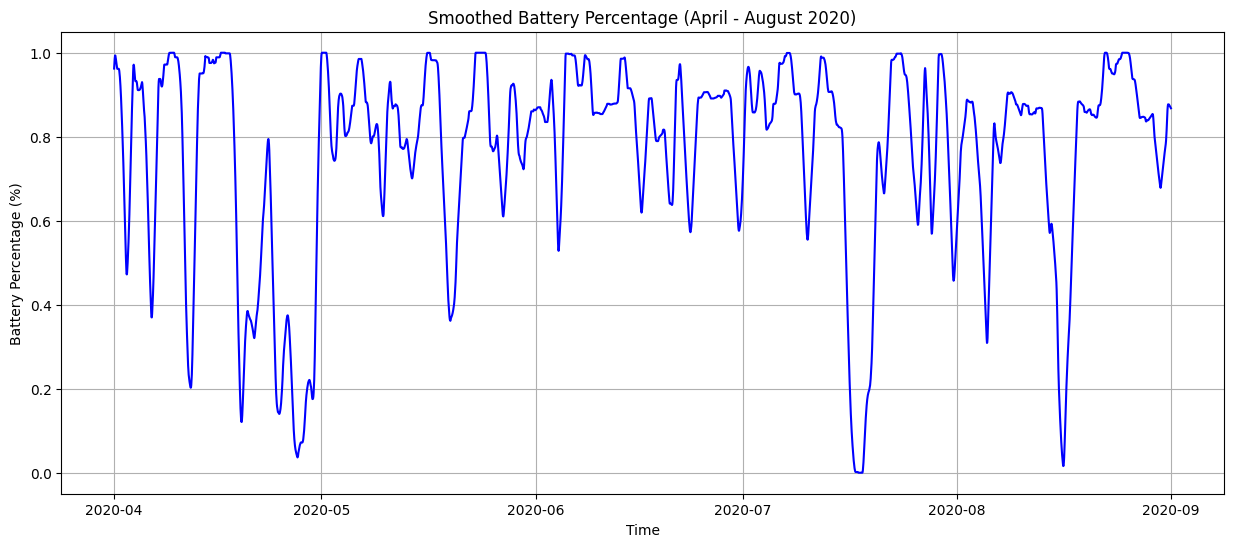

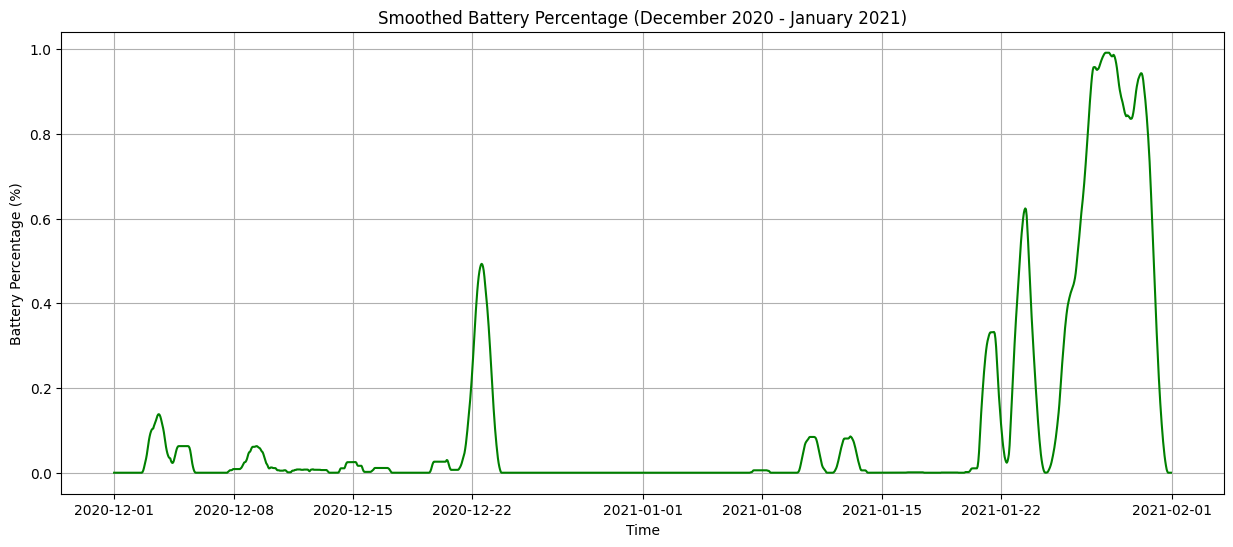

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert 'timestamp' to datetime if not already
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Resample to hourly averages
hourly_data = data.set_index('timestamp')

# Apply a rolling average (24-hour window for smoothing)
hourly_data['smoothed_battery'] = hourly_data['battery_percentage'].rolling(window=24, min_periods=1).mean()

# Define the time ranges
april_to_august = hourly_data['2020-04':'2020-08']
december_to_january = hourly_data['2020-12':'2021-01']

# Plot for April to August 2020
plt.figure(figsize=(15, 6))
plt.plot(april_to_august.index, april_to_august['smoothed_battery'], color='blue', linewidth=1.5)
plt.title('Smoothed Battery Percentage (April - August 2020)')
plt.xlabel('Time')
plt.ylabel('Battery Percentage (%)')
plt.grid(True)
plt.show()

# Plot for December 2020 to January 2021
plt.figure(figsize=(15, 6))
plt.plot(december_to_january.index, december_to_january['smoothed_battery'], color='green', linewidth=1.5)
plt.title('Smoothed Battery Percentage (December 2020 - January 2021)')
plt.xlabel('Time')
plt.ylabel('Battery Percentage (%)')
plt.grid(True)
plt.show()


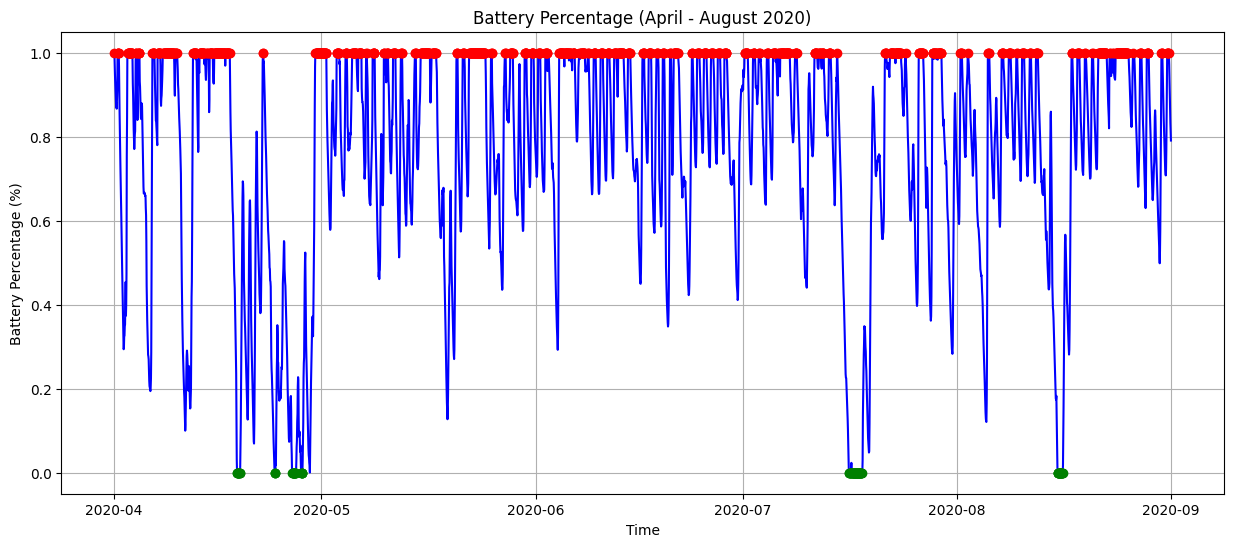

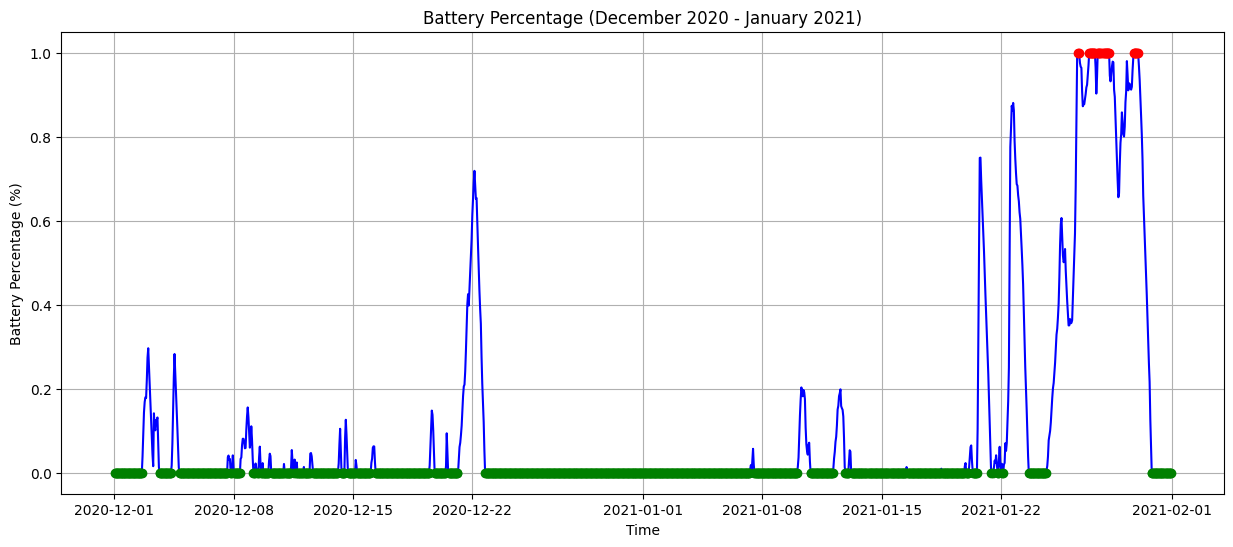

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert 'timestamp' to datetime if not already
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Resample to hourly averages (if needed)
hourly_data = data.set_index('timestamp')

# Define the time ranges
april_to_august = hourly_data['2020-04':'2020-08']
december_to_january = hourly_data['2020-12':'2021-01']

# Function to plot with color changes only when battery is 0 or 1 (using points)
def plot_with_color_changes(data, title):
    plt.figure(figsize=(15, 6))

    # Plot the raw data (battery_percentage) as a line
    plt.plot(data.index, data['battery_percentage'], color='blue', linewidth=1.5)

    # Highlight points where battery_percentage is 0 or 1
    for i in range(1, len(data)):
        if data['battery_percentage'].iloc[i] == 1:  # Electricity thrown away
            plt.scatter(data.index[i], data['battery_percentage'].iloc[i], color='red', zorder=5)  # Plot just a point
        elif data['battery_percentage'].iloc[i] == 0:  # Electricity bought from grid
            plt.scatter(data.index[i], data['battery_percentage'].iloc[i], color='green', zorder=5)  # Plot just a point

    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Battery Percentage (%)')
    plt.grid(True)
    plt.show()

# Plot for April to August 2020
plot_with_color_changes(april_to_august, 'Battery Percentage (April - August 2020)')

# Plot for December 2020 to January 2021
plot_with_color_changes(december_to_january, 'Battery Percentage (December 2020 - January 2021)')


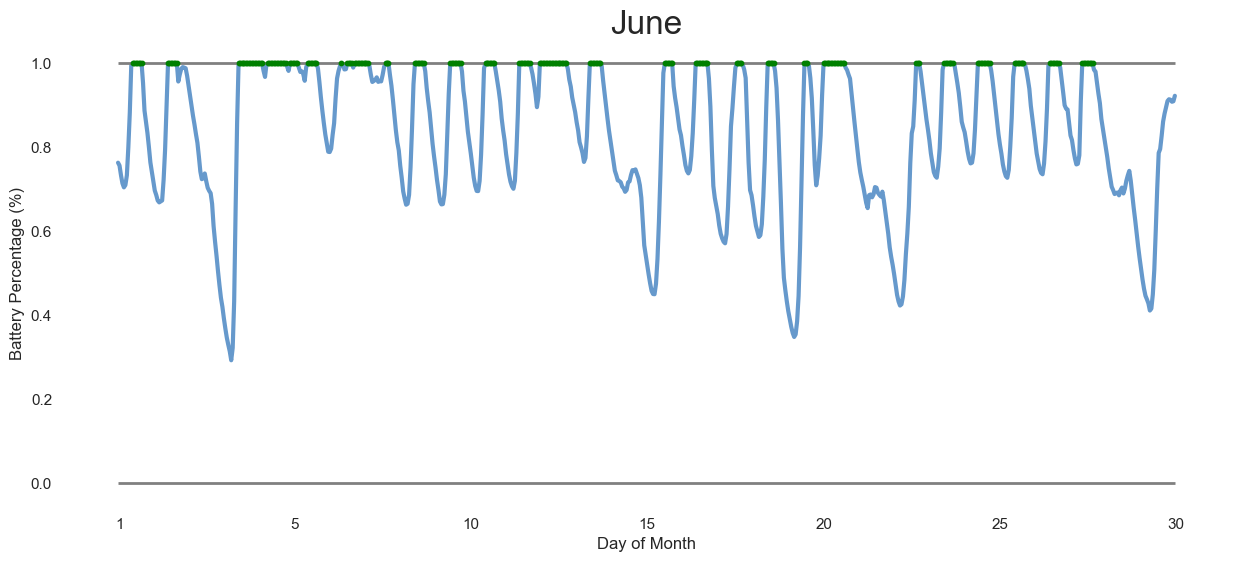

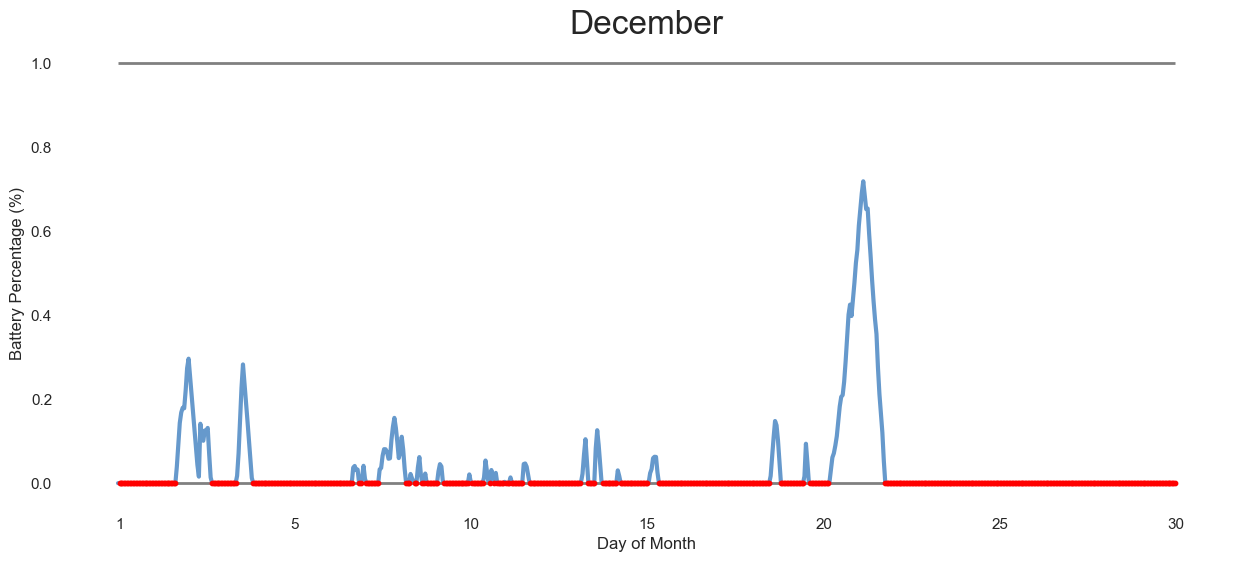

In [175]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Convert 'timestamp' to datetime if not already
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Resample to hourly averages (if needed)
hourly_data = data.set_index('timestamp')

# Use .loc for date slicing
june_data = hourly_data.loc['2020-06']
december_data = hourly_data.loc['2020-12']

# Filter for the first 30 days of June and December
june_data_30 = june_data[june_data.index.day <= 30]
december_data_30 = december_data[december_data.index.day <= 30]

june_data_30 = june_data_30.reset_index()
december_data_30 = december_data_30.reset_index()

# Function to plot with color changes only when battery is 0 or 1 (using points and raw data)
def plot_with_color_changes(data, title):
    plt.figure(figsize=(15, 6))

    # Plot the raw data (battery_percentage) as a line
    plt.plot(data.index, data['battery_percentage'], color='#6699CC', linewidth=3)

    # Highlight points where battery_percentage is 0 or 1
    for i in range(1, len(data)):
        if data['battery_percentage'].iloc[i] == 1:
            plt.scatter(data.index[i], data['battery_percentage'].iloc[i], color='green', zorder=5, s=10)
        elif data['battery_percentage'].iloc[i] == 0:
            plt.scatter(data.index[i], data['battery_percentage'].iloc[i], color='red', zorder=5, s=10)

    # Draw thick grey horizontal lines at 0 and 1
    plt.hlines([0, 1], xmin=data.index.min(), xmax=data.index.max(), colors='grey', linestyles='-', linewidth=2)

        # Remove the frame around the plot
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    
    # Adjust y-axis limits to add space above and below
    plt.ylim(-0.05, 1.05)  # Adds space below 0 and above 1
    
    plt.title(title, fontsize = 24)
    plt.xlabel('Day of Month', fontsize=12)
    plt.ylabel('Battery Percentage (%)', fontsize=12)

    # Custom x-ticks (every 5th day)
    plt.xticks(ticks=[1, 120, 240, 360, 480, 600, 720], labels=[1, 5, 10, 15, 20, 25, 30])

    plt.grid(False)  # Disable default gridlines
    plt.show()

# Plot for June 2020 (no y-axis cap)
plot_with_color_changes(june_data_30, 'June')

# Plot for December 2020 with y-axis capped
plot_with_color_changes(december_data_30, 'December')

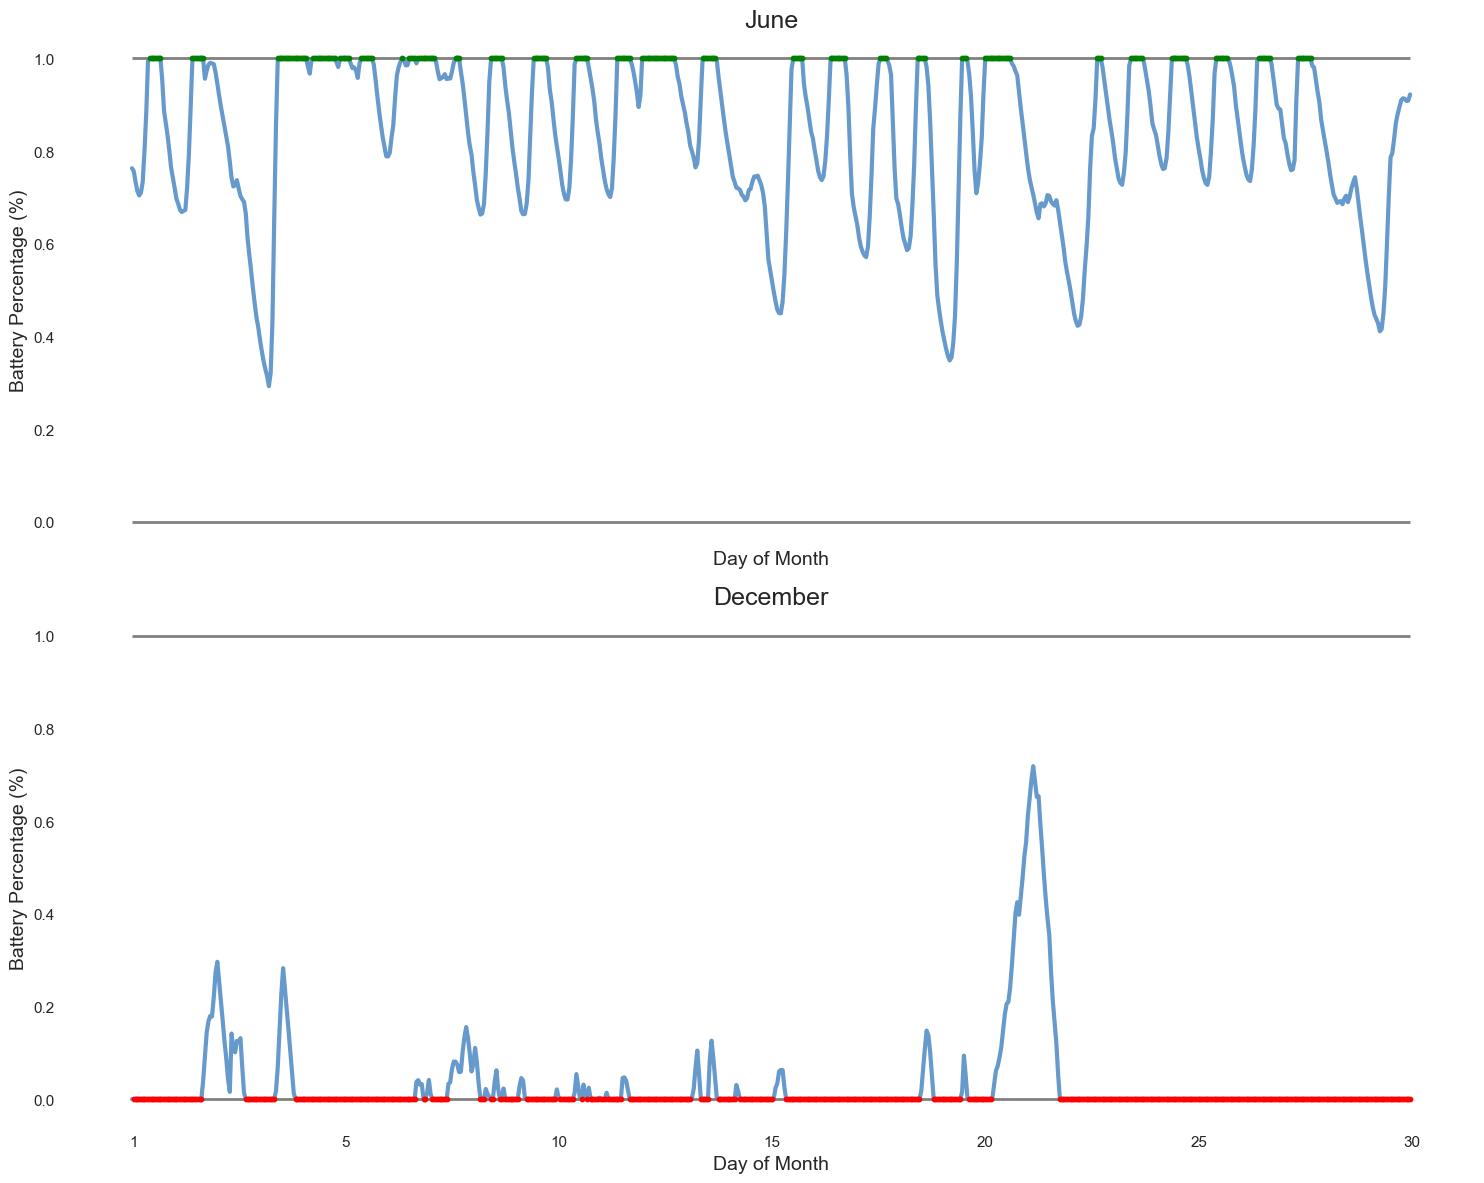

In [169]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Convert 'timestamp' to datetime if not already
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Resample to hourly averages (if needed)
hourly_data = data.set_index('timestamp')

# Use .loc for date slicing
june_data = hourly_data.loc['2020-06']
december_data = hourly_data.loc['2020-12']

# Filter for the first 30 days of June and December
june_data_30 = june_data[june_data.index.day <= 30]
december_data_30 = december_data[december_data.index.day <= 30]

june_data_30 = june_data_30.reset_index()
december_data_30 = december_data_30.reset_index()

# Function to plot with color changes only when battery is 0 or 1 (using points and raw data)
def plot_with_color_changes(ax, data, title):
    # Plot the raw data (battery_percentage) as a line with a lighter blue color
    ax.plot(data.index, data['battery_percentage'], color='#6699CC', linewidth=3)

    # Highlight points where battery_percentage is 0 or 1
    for i in range(1, len(data)):
        if data['battery_percentage'].iloc[i] == 1:
            ax.scatter(data.index[i], data['battery_percentage'].iloc[i], color='green', zorder=5, s=10)
        elif data['battery_percentage'].iloc[i] == 0:
            ax.scatter(data.index[i], data['battery_percentage'].iloc[i], color='red', zorder=5, s=10)

    # Draw thick grey horizontal lines at 0 and 1
    ax.hlines([0, 1], xmin=data.index.min(), xmax=data.index.max(), colors='grey', linestyles='-', linewidth=2)

    # Adjust y-axis limits to add space above and below
    ax.set_ylim(-0.05, 1.05)  # Adds space below 0 and above 1

    # Remove the frame around the plot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # Customize title and labels
    ax.set_title(title, fontsize=18)
    ax.set_xlabel('Day of Month', fontsize=14)
    ax.set_ylabel('Battery Percentage (%)', fontsize=14)

    # Custom x-ticks (every 5th day)
    ax.set_xticks([1, 120, 240, 360, 480, 600, 720])
    ax.set_xticklabels([1, 5, 10, 15, 20, 25, 30])

    ax.grid(False)  # Disable default gridlines

# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(15, 12), sharex=True)  # Two subplots vertically stacked

# Plot for June 2020 on the first subplot
plot_with_color_changes(axs[0], june_data_30, 'June')

# Plot for December 2020 on the second subplot
plot_with_color_changes(axs[1], december_data_30, 'December')

# Adjust the layout to prevent overlap and add space between subplots
plt.tight_layout()

# Show the plot with both figures and the line in between
plt.show()


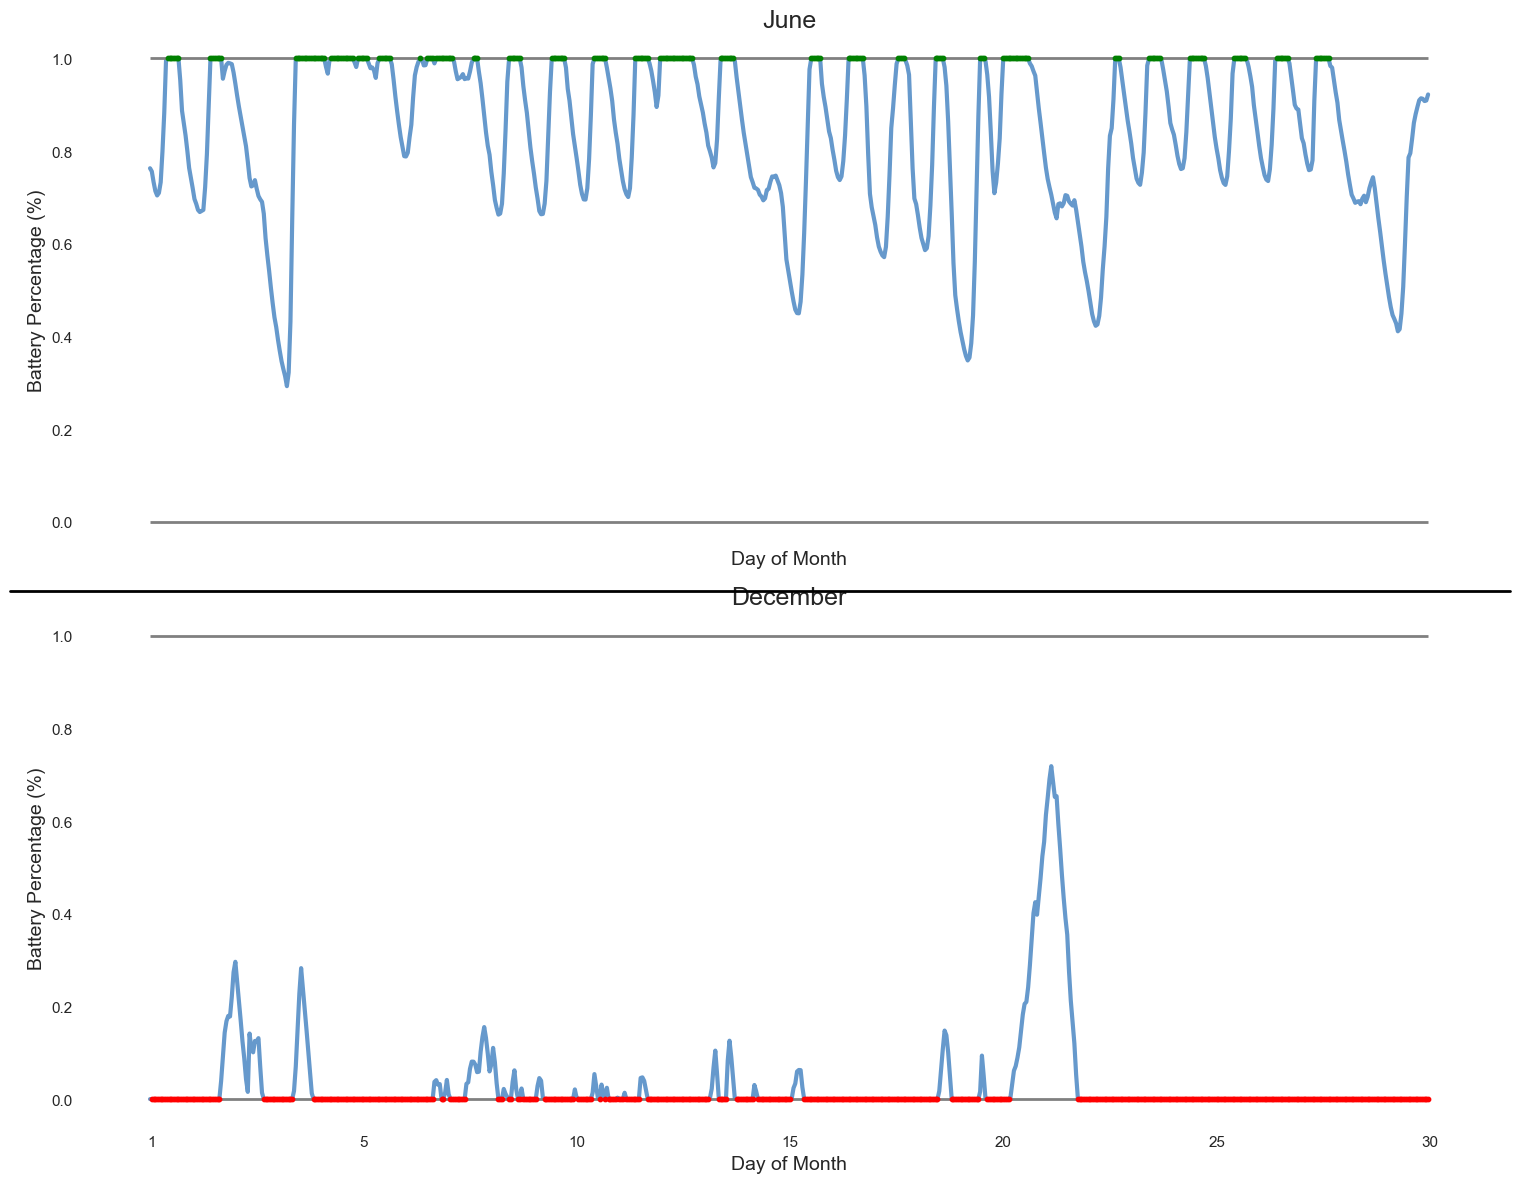

In [171]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D

# Convert 'timestamp' to datetime if not already
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Resample to hourly averages (if needed)
hourly_data = data.set_index('timestamp')

# Use .loc for date slicing
june_data = hourly_data.loc['2020-06']
december_data = hourly_data.loc['2020-12']

# Filter for the first 30 days of June and December
june_data_30 = june_data[june_data.index.day <= 30]
december_data_30 = december_data[december_data.index.day <= 30]

june_data_30 = june_data_30.reset_index()
december_data_30 = december_data_30.reset_index()

# Function to plot with color changes only when battery is 0 or 1 (using points and raw data)
def plot_with_color_changes(ax, data, title):
    # Plot the raw data (battery_percentage) as a line with a lighter blue color
    ax.plot(data.index, data['battery_percentage'], color='#6699CC', linewidth=3)

    # Highlight points where battery_percentage is 0 or 1
    for i in range(1, len(data)):
        if data['battery_percentage'].iloc[i] == 1:
            ax.scatter(data.index[i], data['battery_percentage'].iloc[i], color='green', zorder=5, s=10)
        elif data['battery_percentage'].iloc[i] == 0:
            ax.scatter(data.index[i], data['battery_percentage'].iloc[i], color='red', zorder=5, s=10)

    # Draw thick grey horizontal lines at 0 and 1
    ax.hlines([0, 1], xmin=data.index.min(), xmax=data.index.max(), colors='grey', linestyles='-', linewidth=2)

    # Adjust y-axis limits to add space above and below
    ax.set_ylim(-0.05, 1.05)  # Adds space below 0 and above 1

    # Remove the frame around the plot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # Customize title and labels
    ax.set_title(title, fontsize=18)
    ax.set_xlabel('Day of Month', fontsize=14)
    ax.set_ylabel('Battery Percentage (%)', fontsize=14)

    # Custom x-ticks (every 5th day)
    ax.set_xticks([1, 120, 240, 360, 480, 600, 720])
    ax.set_xticklabels([1, 5, 10, 15, 20, 25, 30])

    ax.grid(False)  # Disable default gridlines

# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(15, 12), sharex=True)  # Two subplots vertically stacked

# Plot for June 2020 on the first subplot
plot_with_color_changes(axs[0], june_data_30, 'June')

# Plot for December 2020 on the second subplot
plot_with_color_changes(axs[1], december_data_30, 'December')

# Add a line between the two subplots (vertical line at the center between them)
line = Line2D([0, 1], [0.5, 0.5], color='black', linewidth=2, transform=fig.transFigure, clip_on=False)
fig.add_artist(line)

# Adjust the layout to prevent overlap and add space between subplots
plt.tight_layout()

# Show the plot with both figures and the line between them
plt.show()


# Archive

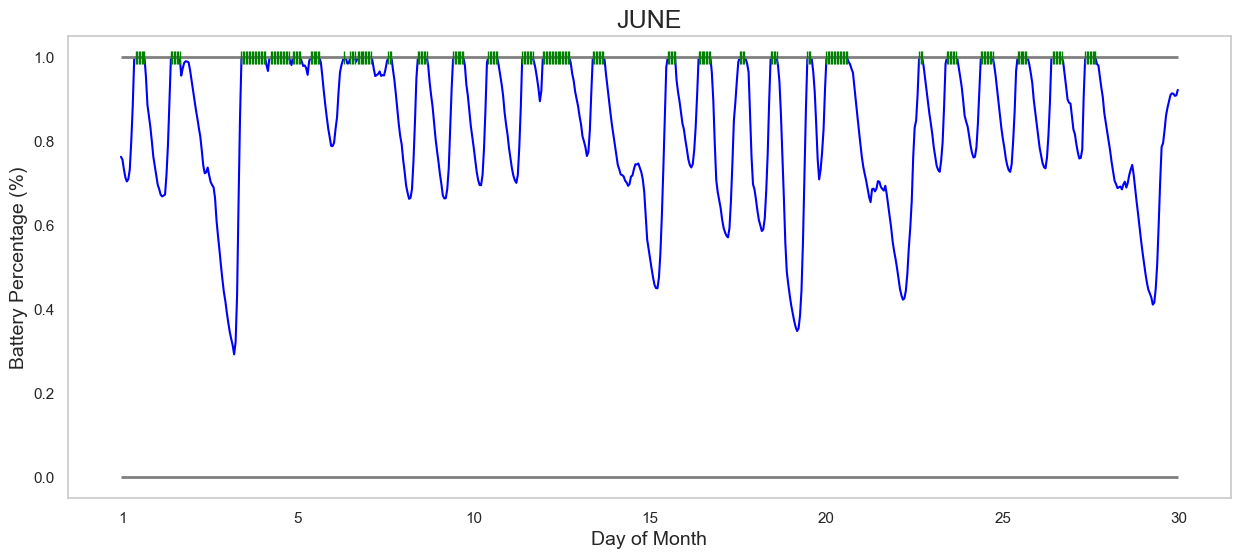

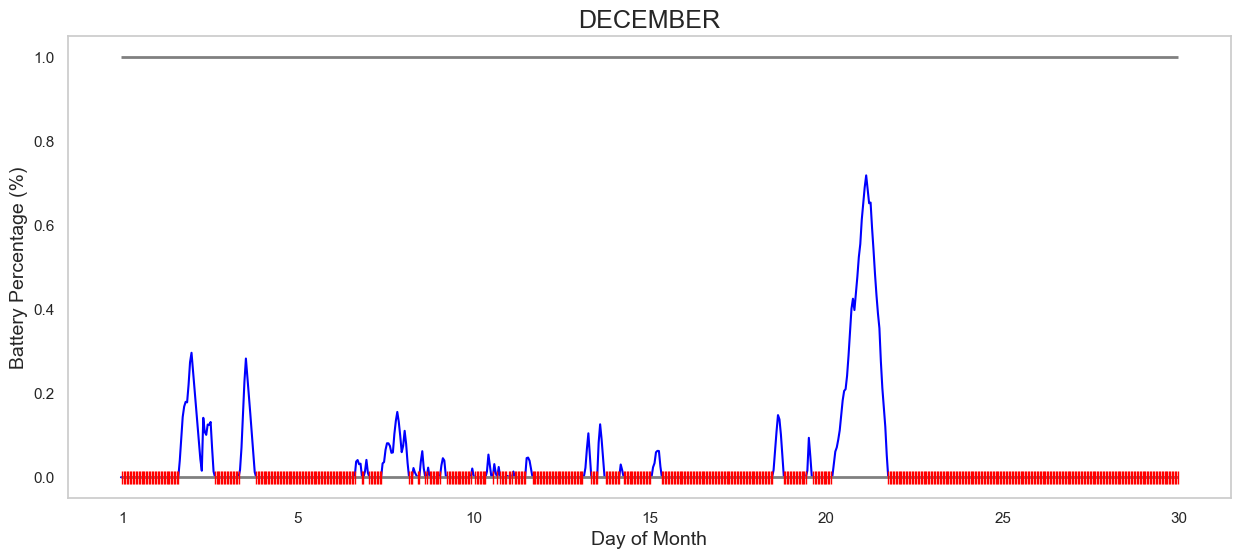

In [163]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Convert 'timestamp' to datetime if not already
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Resample to hourly averages (if needed)
hourly_data = data.set_index('timestamp')

# Use .loc for date slicing
june_data = hourly_data.loc['2020-06']
december_data = hourly_data.loc['2020-12']

# Filter for the first 30 days of June and December
june_data_30 = june_data[june_data.index.day <= 30]
december_data_30 = december_data[december_data.index.day <= 30]

june_data_30 = june_data_30.reset_index()
december_data_30 = december_data_30.reset_index()

# Function to plot with color changes only when battery is 0 or 1 (using points and raw data)
def plot_with_color_changes(data, title, cap_y=False):
    plt.figure(figsize=(15, 6))

    # Plot the raw data (battery_percentage) as a line
    plt.plot(data.index, data['battery_percentage'], color='blue', linewidth=1.5)

    # Highlight points where battery_percentage is 0 or 1
    # Highlight points where battery_percentage is 0 or 1
# Highlight points where battery_percentage is 0 or 1 with short vertical lines
    for i in range(1, len(data)):
        if data['battery_percentage'].iloc[i] == 1:  # Electricity thrown away
            plt.vlines(data.index[i], 0.985, 1.015, color='green', zorder=5, linewidth=1)  # Short vertical line
        elif data['battery_percentage'].iloc[i] == 0:  # Electricity bought from grid
            plt.vlines(data.index[i], -0.015, 0.015, color='red', zorder=5, linewidth=1)  # Short vertical line



    # Draw thick grey horizontal lines at 0 and 1
    plt.hlines([0, 1], xmin=data.index.min(), xmax=data.index.max(), colors='grey', linestyles='-', linewidth=2)

    # Adjust y-axis limits to add space above and below
    plt.ylim(-0.05, 1.05)  # Adds space below 0 and above 1
    
    plt.title(title, fontsize = 18)
    plt.xlabel('Day of Month', fontsize=14)
    plt.ylabel('Battery Percentage (%)', fontsize=14)

    # Custom x-ticks (every 5th day)
    plt.xticks(ticks=[1, 120, 240, 360, 480, 600, 720], labels=[1, 5, 10, 15, 20, 25, 30])

    plt.grid(False)  # Disable default gridlines
    plt.show()

# Plot for June 2020 (no y-axis cap)
plot_with_color_changes(june_data_30, 'JUNE')

# Plot for December 2020 with y-axis capped
plot_with_color_changes(december_data_30, 'DECEMBER')


/var/folders/8j/4b_jqpvj0ln3qkhkk92s38240000gn/T/ipykernel_12833/1819887474.py:12: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  june_data = hourly_data['2020-06']
/var/folders/8j/4b_jqpvj0ln3qkhkk92s38240000gn/T/ipykernel_12833/1819887474.py:13: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  december_data = hourly_data['2020-12']


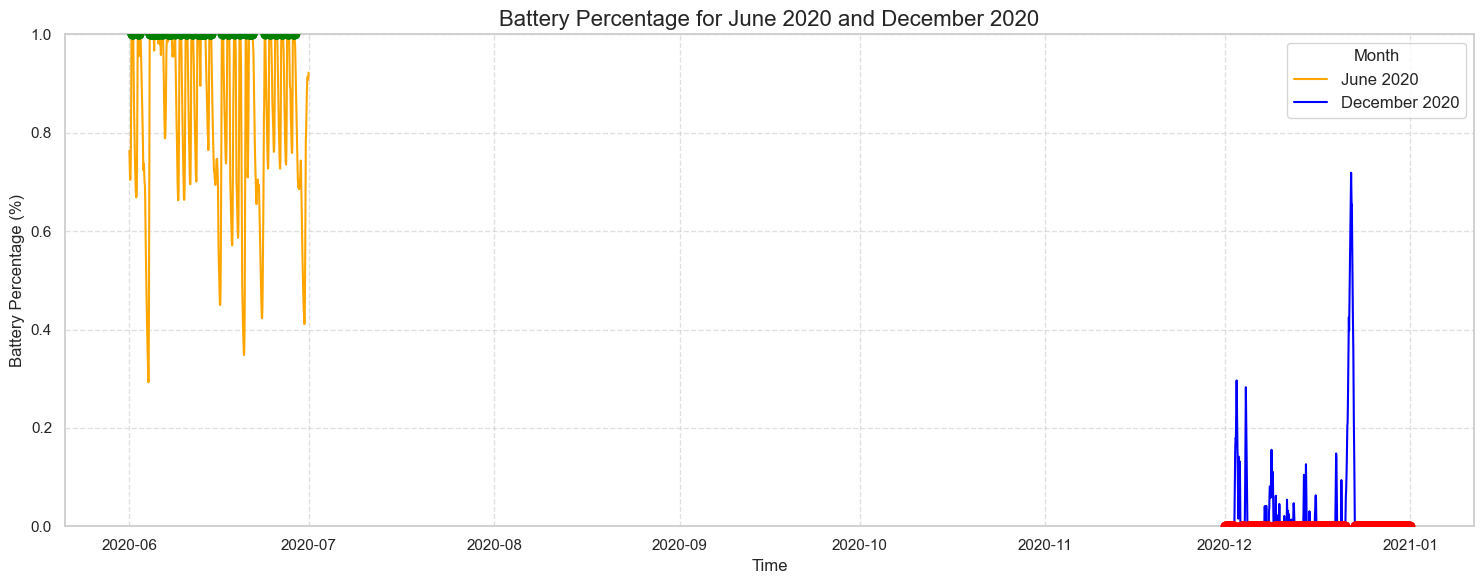

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert 'timestamp' to datetime if not already
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Resample to hourly averages (if needed)
hourly_data = data.set_index('timestamp')

# Filter data for June and December
june_data = hourly_data['2020-06']
december_data = hourly_data['2020-12']

# Set Seaborn style for better visualization
sns.set(style="whitegrid", palette="muted")

# Function to plot with color changes only when battery is 0 or 1 (using points and raw data)
def plot_with_color_changes_combined(june_data, december_data):
    plt.figure(figsize=(15, 6))

    # Plot June 2020 data in orange
    plt.plot(june_data.index, june_data['battery_percentage'], color='orange', linewidth=1.5, label='June 2020')

    # Plot December 2020 data in blue
    plt.plot(december_data.index, december_data['battery_percentage'], color='blue', linewidth=1.5, label='December 2020')

    # Highlight points where battery_percentage is 0 or 1 for June (orange)
    for i in range(1, len(june_data)):
        if june_data['battery_percentage'].iloc[i] == 1:  # Electricity thrown away
            plt.scatter(june_data.index[i], june_data['battery_percentage'].iloc[i], color='green', zorder=5)  # Plot just a point
        elif june_data['battery_percentage'].iloc[i] == 0:  # Electricity bought from grid
            plt.scatter(june_data.index[i], june_data['battery_percentage'].iloc[i], color='red', zorder=5)  # Plot just a point

    # Highlight points where battery_percentage is 0 or 1 for December (blue)
    for i in range(1, len(december_data)):
        if december_data['battery_percentage'].iloc[i] == 1:  # Electricity thrown away
            plt.scatter(december_data.index[i], december_data['battery_percentage'].iloc[i], color='green', zorder=5)  # Plot just a point
        elif december_data['battery_percentage'].iloc[i] == 0:  # Electricity bought from grid
            plt.scatter(december_data.index[i], december_data['battery_percentage'].iloc[i], color='red', zorder=5)  # Plot just a point

    # Add title, labels, and a legend
    plt.title('Battery Percentage for June 2020 and December 2020', fontsize=16)
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Battery Percentage (%)', fontsize=12)
    plt.legend(title="Month", loc="upper right", fontsize=12)
    
    # Set y-axis limits
    plt.ylim(0, 1)
    
    # Enhance the grid and make it visually appealing
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # Show the plot
    plt.tight_layout()
    plt.show()

# Plot for both June and December data on the same graph
plot_with_color_changes_combined(june_data, december_data)


In [115]:
june_data.index.day

Int64Index([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
            ...
            30, 30, 30, 30, 30, 30, 30, 30, 30, 30],
           dtype='int64', name='timestamp', length=720)

In [118]:
june_data_30

,timestamp,actual_consumption,actual_production,electricity_price,excess_production_kwH,battery_percentage,electricity_bought_kwH,electricity_bought_NOK,electricity_sold_kwH,electricity_sold_NOK
0,2020-06-01 00:00:00,10.893502,1.280000,0.04852,-9.613502,0.763040,0.0,0.0,0.0,0.0
1,2020-06-01 01:00:00,9.950489,6.570000,0.04874,-3.380489,0.756279,0.0,0.0,0.0,0.0
2,2020-06-01 02:00:00,11.812247,0.303750,0.04243,-11.508497,0.733262,0.0,0.0,0.0,0.0
3,2020-06-01 03:00:00,11.128673,1.401167,0.05216,-9.727507,0.713807,0.0,0.0,0.0,0.0
4,2020-06-01 04:00:00,7.299278,2.558667,0.05066,-4.740612,0.704326,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
715,2020-06-30 19:00:00,17.352060,19.499750,0.01593,2.147690,0.914080,0.0,0.0,0.0,0.0
716,2020-06-30 20:00:00,14.346451,13.816167,0.01582,-0.530285,0.913020,0.0,0.0,0.0,0.0
717,2020-06-30 21:00:00,17.204731,14.750000,0.01604,-2.454731,0.908110,0.0,0.0,0.0,0.0
718,2020-06-30 22:00:00,14.115884,14.720000,0.01036,0.604116,0.909319,0.0,0.0,0.0,0.0


/var/folders/8j/4b_jqpvj0ln3qkhkk92s38240000gn/T/ipykernel_12833/2653150900.py:12: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  june_data = hourly_data['2020-06']
/var/folders/8j/4b_jqpvj0ln3qkhkk92s38240000gn/T/ipykernel_12833/2653150900.py:13: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  december_data = hourly_data['2020-12']


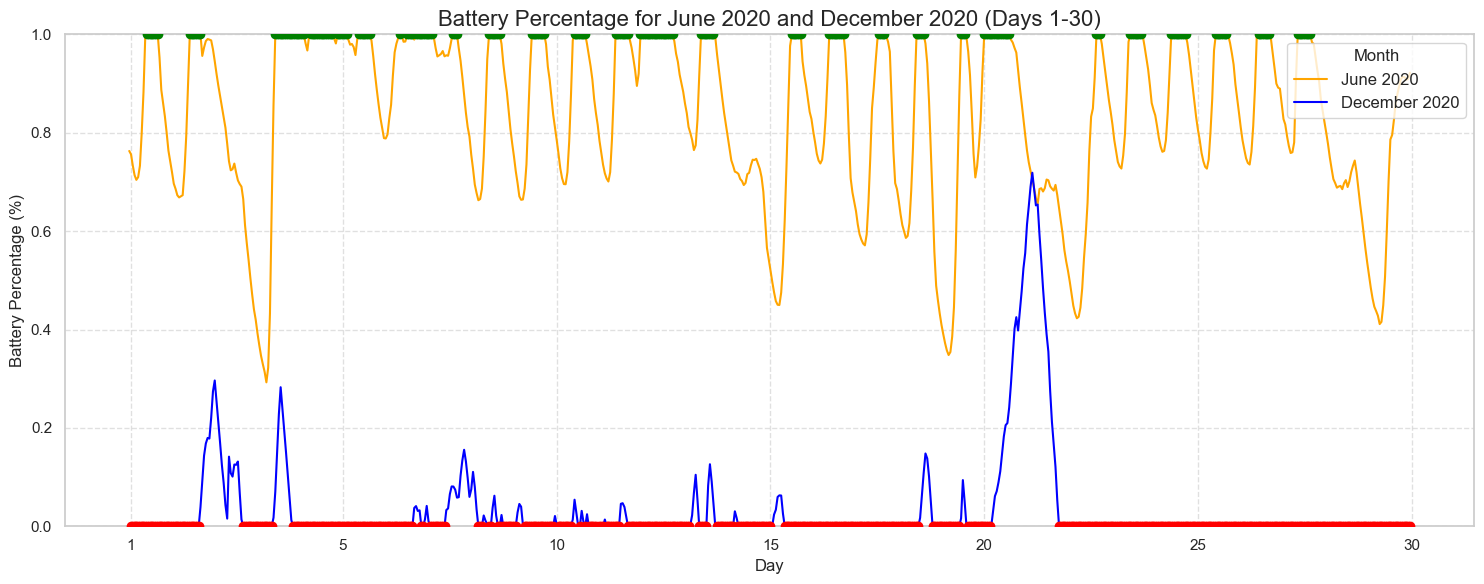

In [133]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert 'timestamp' to datetime if not already
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Resample to hourly averages (if needed)
hourly_data = data.set_index('timestamp')

# Filter data for June and December
june_data = hourly_data['2020-06']
december_data = hourly_data['2020-12']

# Filter for the first 30 days of June and December
june_data_30 = june_data[june_data.index.day <= 30]
december_data_30 = december_data[december_data.index.day <= 30]

june_data_30 = june_data_30.reset_index()
december_data_30 = december_data_30.reset_index()


# Set Seaborn style for better visualization
sns.set(style="whitegrid", palette="muted")

# Function to plot with color changes only when battery is 0 or 1 (using points and raw data)
def plot_with_color_changes_combined(june_data, december_data):
    plt.figure(figsize=(15, 6))

    # Plot June 2020 data in orange
    plt.plot(june_data.index, june_data['battery_percentage'], color='orange', linewidth=1.5, label='June 2020')

    # Plot December 2020 data in blue
    plt.plot(december_data.index, december_data['battery_percentage'], color='blue', linewidth=1.5, label='December 2020')

    # Highlight points where battery_percentage is 0 or 1 for June (orange)
    for i in range(1, len(june_data)):
        if june_data['battery_percentage'].iloc[i] == 1:  # Electricity thrown away
            plt.scatter(june_data.index[i], june_data['battery_percentage'].iloc[i], color='green', zorder=5)  # Plot just a point
        elif june_data['battery_percentage'].iloc[i] == 0:  # Electricity bought from grid
            plt.scatter(june_data.index[i], june_data['battery_percentage'].iloc[i], color='red', zorder=5)  # Plot just a point

    # Highlight points where battery_percentage is 0 or 1 for December (blue)
    for i in range(1, len(december_data)):
        if december_data['battery_percentage'].iloc[i] == 1:  # Electricity thrown away
            plt.scatter(december_data.index[i], december_data['battery_percentage'].iloc[i], color='green', zorder=5)  # Plot just a point
        elif december_data['battery_percentage'].iloc[i] == 0:  # Electricity bought from grid
            plt.scatter(december_data.index[i], december_data['battery_percentage'].iloc[i], color='red', zorder=5)  # Plot just a point
    
    # Add title, labels, and a legend
    plt.title('Battery Percentage for June 2020 and December 2020 (Days 1-30)', fontsize=16)
    plt.xlabel('Day', fontsize=12)
    plt.ylabel('Battery Percentage (%)', fontsize=12)
    plt.legend(title="Month", loc="upper right", fontsize=12)
    
    # Set y-axis limits
    plt.ylim(0, 1)
    
    # Enhance the grid and make it visually appealing
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.xticks(ticks = [1, 120, 240, 360, 480, 600, 720], labels = [1, 5, 10, 15, 20, 25, 30])
    
    # Show the plot
    plt.tight_layout()
    plt.show()

# Plot for both June and December data on the same graph for the first 30 days
plot_with_color_changes_combined(june_data_30, december_data_30)
